# Create a dataset of non-digits from MNIST

Can we create a dataset of non-digits that can be used (by mnist-or-not-training.ipynb) to train a model that tells us if a hand-drawn image is a digit or not?

While it'd be easy to use characters etc from EMNIST, I'm interested to see if using non-digit images that
- have features of digits (i.e. are made up of parts of digit images) but
- are not valid digits (and are mostly not valid characters or symbols of any kind)

can be used to create a model that will generalize to hand drawn characters, symbols, scribbles etc

| conversion                                 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | notes                 |
|--------------------------------------------|---|---|---|---|---|---|---|---|---|---|-----------------------|
| zero 1 square at random (1 quarter size)   | y |   | y | y | y | y | y | y | y | y |                       |
| zero 1 quadrant                            | y |   | y | y | y | y | y | y | y | y |                       |
| zero 1 half vertical                       | y | y | y | y | y | y | y | y | y | y |                       |
| zero 1 half horizontally                   | y |   | y | y | y | y | y | y | y | y |                       |
| flip top half vertically                   | y |   | y | y | y | y | y | y |   |   |                       |
| flip vertial                               |   |   | y |   | y | y | y | y |   | y |                       |
| flip horizontal                            |   |   | y | y | y | y | y | y |   | y |                       |
| overlay a different number                 | y | y | y | y | y | y | y | y | y | y | 8 and 6 might make 8! |
| overlay same digit rotated 90, 270         |   | y | y | y | y | y | y | y | y | y |                       |
| overlay same digit rotated 180             |   |   | y |   | y | y |   | y |   |   |                       |
| random scribble                            | y | y | y | y | y | y | y | y | y | y |                       |
| half of 1 number joined to half of another |   |   |   |   |   |   |   |   |   |   |                       |
| Rotate: 90, 270                            |   | y | y | y | y | y | y | y | y | y |                       |
| Rotate: 180                                |   |   | y | y | y | y |   | y |   |   |                       |
| smiley face                                | y |   |   |   |   |   |   |   |   |   |                       |

See: https://thisdavej.com/copy-table-in-excel-and-paste-as-a-markdown-table/

In [1]:
import torch
from torchvision.transforms import functional as F
from torch.nn.functional import interpolate,pad
from PIL import Image
from fastai.datasets import untar_data,URLs
from random import choice,randint,uniform
from functools import partial
import inspect

In [2]:
path = untar_data(URLs.MNIST); path

PosixPath('/home/peter/.fastai/data/mnist_png')

In [3]:
img0_path=path/'training/0/210.png'
img0=Image.open(img0_path)
img4_path=path/'training/4/354.png'
img4=Image.open(img4_path)
img4

## Define functions that can convert a digit into something that is not a digit

converter functions can take either 1 or 4 arguments
- img (a PIL Image)
- img, input_path (the path we're reading from), kind (training or testing), digit (which digit is img)

You can see below that `_create_not_digits` uses `can_call_with_n_positional_args` to know how many args to pass

In [4]:
def open_random(input_path, kind, digits):
    "pick an image at random that is of the right `kind` and is one of `digits`"
    path=input_path/f'{kind}/{choice(digits)}'
    return Image.open(choice(list(path.iterdir())))

In [5]:
open_random(path, 'training', [0,1,2,3])

In [6]:
F.vflip(img4)

In [7]:
F.hflip(img4)

In [8]:
def rotate(img,angle=90):
    return img.rotate(angle)

In [9]:
rotate(img4, 270) # F.rotate -> error )o:

In [10]:
rotate_180=partial(rotate,angle=180)
rotate_270=partial(rotate,angle=270)

In [11]:
rotate_180(img4)

In [12]:
def erase_quadrant(img,i=0,j=0,v=0):
    return F.to_pil_image(F.erase(F.to_tensor(img),i,j,14,14,v))

In [13]:
erase_quadrant(img4)

In [14]:
erase_quadrant(img4,14,14)

In [15]:
erase_quadrant(img4.rotate(45),0,0,.75).rotate(-45)

In [16]:
def erase_random_quadrant(img):
    i,j=randint(0,1)*14,randint(0,1)*14
    return F.to_pil_image(F.erase(F.to_tensor(img),i,j,14,14,0))

In [17]:
erase_random_quadrant(img0)

In [18]:
def erase_random_square(img):
    i,j=randint(0,14),randint(0,14)
    return F.to_pil_image(F.erase(F.to_tensor(img),i,j,14,14,0))

In [19]:
erase_random_square(img4)

In [20]:
def overlay_rotated(img, img2=None, angle=90):
    a=F.to_tensor(img)
    b=F.to_tensor((img if img2 is None else img2).rotate(angle))
    return F.to_pil_image(torch.clamp(a+b,0,1))

In [21]:
overlay_rotated(img4,img0,0)

In [22]:
overlay_rotated(img4)

In [23]:
def overlay_with_random(img,input_path,kind,digit):
    digits=[i for i in range(10) if i!=digit]
    img2=open_random(input_path,kind,digits)
    return overlay_rotated(img,img2,randint(0,359))

In [24]:
overlay_with_random(img0,path,'training',0)

In [25]:
def hsplice(img1,img2):
    a=F.to_tensor(img1)[:,0:14,0:28]
    b=F.to_tensor(img2)[:,15:28,0:28]
    return F.to_pil_image(torch.cat([a,b],1))

In [26]:
hsplice(img0,img4)

In [27]:
hsplice(img4,img0)

In [28]:
def hsplice_with_random(img,input_path,kind,digit):
    digits=[i for i in range(10) if i!=digit]
    imgs=[img, open_random(input_path,kind,digits)]
    if randint(0,1): imgs.reverse()
    return hsplice(*imgs)

In [29]:
hsplice_with_random(img0,path,'training',0)

In [30]:
def flip_half(img,part='top'): # top, bottom, both
    t=F.to_tensor(img)
    a=t[:,0:14,0:28]
    b=t[:,15:28,0:28]
    if part in ['top','both']: a=a.flip([1])
    if part in ['bottom','both']: b=b.flip([1])
    return F.to_pil_image(torch.cat([a,b],1))

In [31]:
flip_half(img4, 'both')

In [32]:
def flip_half_random(img):
    return flip_half(img,choice(['top','bottom','both']))

In [33]:
flip_half_random(img0)

In [36]:
def smile(img):
    "convert a zero into a smiley face"
    t=F.to_tensor(img)
    eye=F.to_tensor(img0.resize((8,8)))
    eye=eye*(uniform(.75,.95)/eye.max())
    eyes=torch.cat([eye,eye],2)
    eyes=pad(eyes,(6,6,8,12))
    mouth=t[:,22:28,0:28]
    mouth=torch.cat([torch.zeros(1,17,28),mouth,torch.zeros(1,5,28)],1)
    smiley=torch.clamp(t+eyes+mouth,0,1)
    return F.to_pil_image(smiley)

In [37]:
smile(img0)

## Create the `mnist_or_not` dataset

### Start by copying MNIST to a new `mnist_or_not` folder

In [38]:
from pathlib import Path
def cp_mnist(kind):
    p = path/kind
    o = output_path = path.parent/f'mnist_or_not/{kind}'
    print(f'copying from {p} to {o}')
    !cp -r -u $p/. $o

cp_mnist('training')
cp_mnist('testing')

copying from /home/peter/.fastai/data/mnist_png/training to /home/peter/.fastai/data/mnist_or_not/training
copying from /home/peter/.fastai/data/mnist_png/testing to /home/peter/.fastai/data/mnist_or_not/testing


### Read MNIST images, convert to not digits, and save them to the new `mnist_or_not` folder

In [39]:
def can_call_with_n_positional_args(f, n):
    "return true if f can be called with n positional arguments, false otherwise"
    def _len(l): return 0 if l is None else len(l)
    fas = inspect.getfullargspec(f)
    def _min(): return _len(fas.args) - _len(fas.defaults)
    def _max(): return 99999 if fas.varargs else len(fas.args)
    if inspect.ismethod(f): n += 1 # add one for self
    return n >= _min() and n <= _max()

In [40]:
def _create_not_digits(input_path, output_path, kind, digit, converters):
    print('converting', kind, digit)
    (output_path/f'{kind}/not{digit}').mkdir(parents=True, exist_ok=True)
    for i, f in enumerate((input_path/f'{kind}/{digit}').iterdir()):
        converter=converters[i % len(converters)]
        output_file=output_path/f'{kind}/not{digit}/{f.name}'
        args=[Image.open(f)]
        if can_call_with_n_positional_args(converter,4): args=args+[input_path,kind,digit]
        converter(*args).save(output_file)
        
def create_not_digits(path, digit, converters):
    output_path = path.parent/'mnist_or_not'
    _create_not_digits(path, output_path, 'training', digit, converters)
    _create_not_digits(path, output_path, 'testing', digit, converters)

In [42]:
base_converters=[erase_random_square,hsplice_with_random,erase_random_quadrant,overlay_with_random,overlay_with_random]
all_converters=base_converters+[rotate,rotate_180,rotate_270,overlay_rotated,F.vflip,F.hflip]
digits_and_converters={
    0:base_converters+[flip_half_random,smile],
    1:base_converters+[rotate,rotate_270,overlay_rotated],
    2:all_converters,
    3:base_converters+[rotate,rotate_270,overlay_rotated,F.hflip],
    4:all_converters,
    5:all_converters,
    6:base_converters+[rotate,rotate_270,overlay_rotated,F.hflip],
    7:all_converters,
    8:base_converters+[rotate,rotate_270,overlay_rotated],
    9:base_converters+[rotate,rotate_270,overlay_rotated,F.hflip],
}

we could run the conversion sequentially
```python
for digit,converters in digits_and_converters.items():
    create_not_digits(path,digit,converters)
```
but it's faster to use multiple processes (still takes a while - because we're converting one image at a time, on the CPU ...)

In [38]:
from concurrent.futures import ProcessPoolExecutor
paths,digits,converters=[],[],[]
for _digit,_converters in digits_and_converters.items():
    paths.append(path)
    digits.append(_digit)
    converters.append(_converters)
with ProcessPoolExecutor() as executor:
    executor.map(create_not_digits,paths,digits,converters)

converting training 0
converting training 1
converting training 3
converting training 4
converting training 2
converting training 9
converting training 5
converting training 8
converting training 6
converting training 7
converting testing 2
converting testing 6
converting testing 5
converting testing 4
converting testing 7
converting testing 9
converting testing 3
converting testing 8
converting testing 1
converting testing 0


### take a quick look at some of the images in `mnist_or_not`

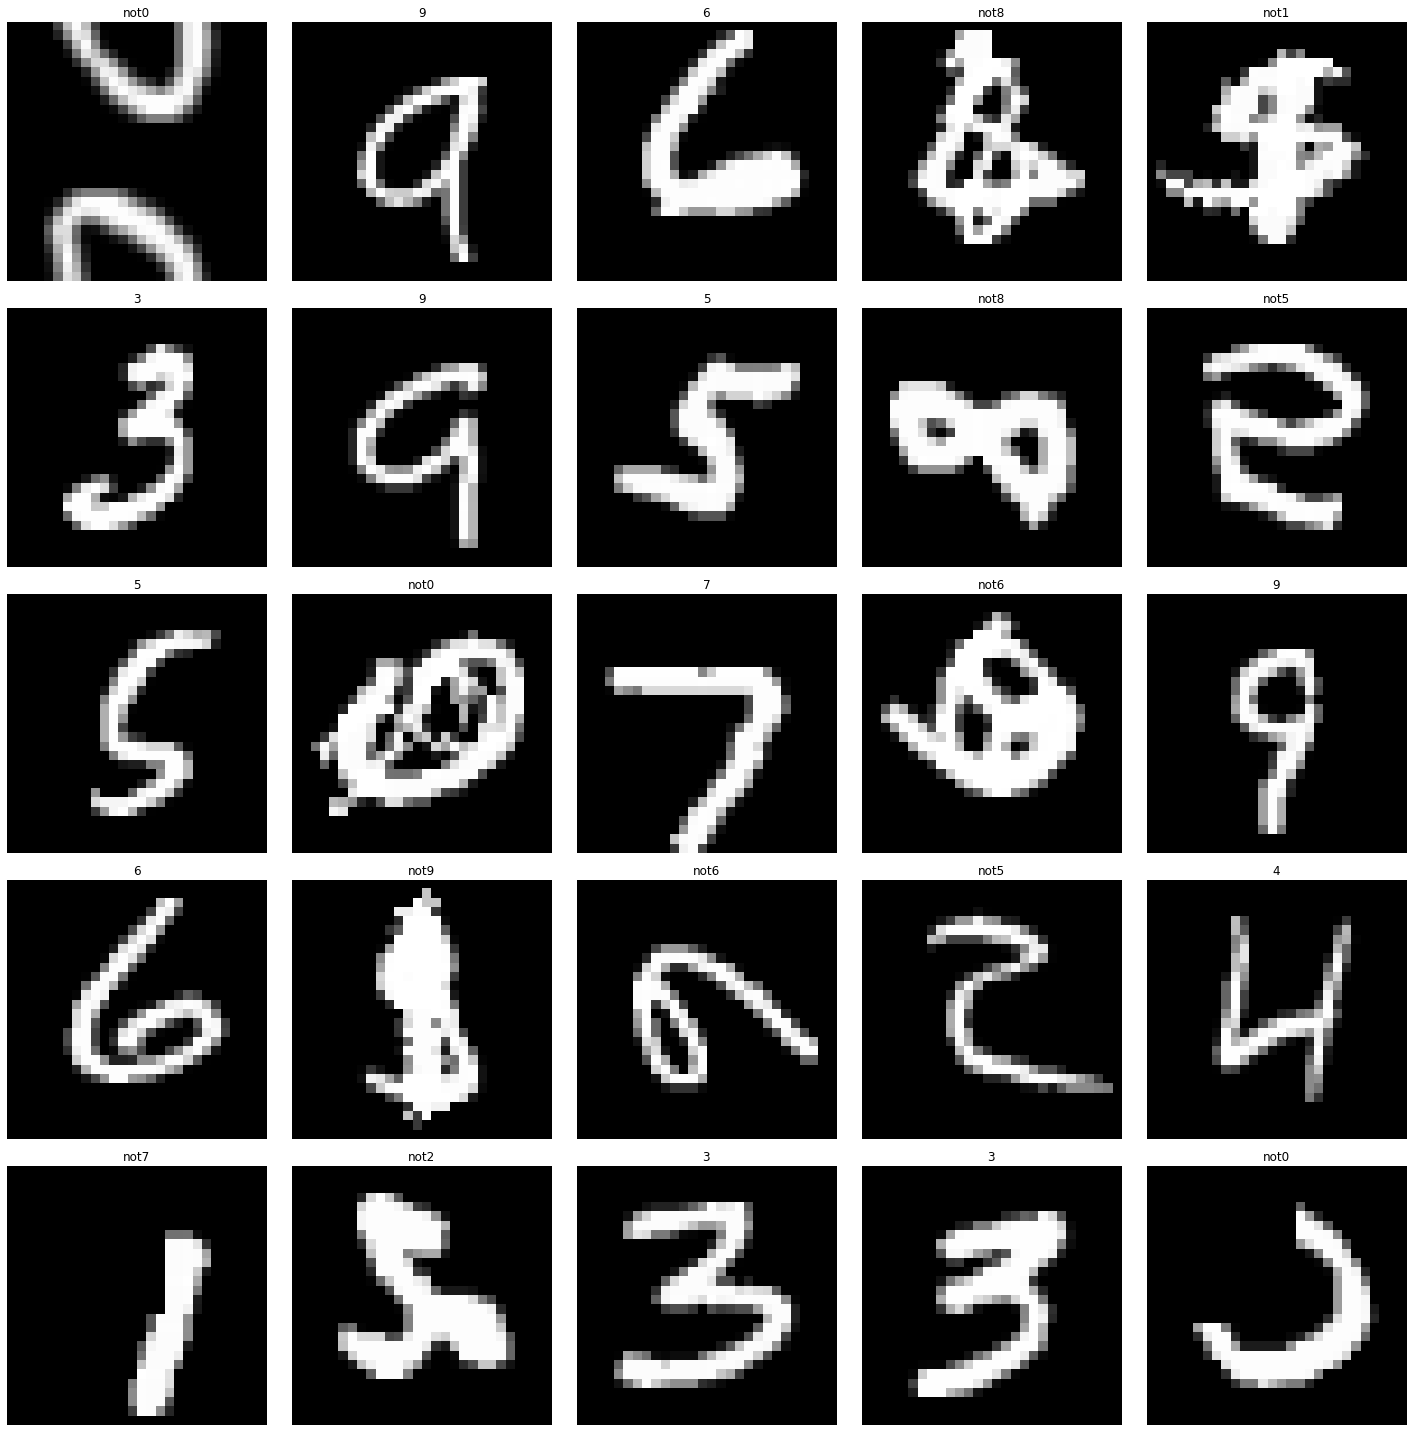

In [45]:
from fastai.vision.data import ImageDataBunch
data = ImageDataBunch.from_folder(path.parent/'mnist_or_not', train='training', valid='testing', size=28, bs=128)
data.show_batch()